# Predicting Sovereign Bond Spreads: Empirical Analysis using Machine Learning Techniques
### by Dennis Prüß

In [30]:
# import standard libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# ML specific libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from panelsplit import PanelSplit
from sklearn.preprocessing import MinMaxScaler

In [31]:
# set options to showcase the whole dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [32]:
# personal filepath 
filepath= '/personal_file/Spreads.csv'

# read data 
df = pd.read_csv(filepath)

# ensure the right date format 
df["Date"] = pd.to_datetime(df["Date"])

print(df.shape)
df.head()

(2040, 154)


,Date,10Y_Spread,Inflation_Rate_YoY,Unemployment_Rate,Retail_Sales_YoY,GDP_Growth_YoY,Consumer_Confidence_Index,Current_Account_Balance_GDP,Debt_to_GDP,Debt_Growth_YoY,Real_Effective_Exchange_Rate,Real_Effective_Exchange_Rate_Pct,Stock_Market_Return_MoM,Stock_Market_Return_YoY,CBOE_Volatility_Index,EUR/USD,US_Yield_Curve_Spread,Baa_Treasury_Spread,ECB_Assets_Change,ECB_Assets_Pct_Change,EURIBOR,EURIBOR_Change,FEDECB,Total_ECB_Purchases,Rating_ordinal,Rating_PD_Pct,Stability_Index,Inflation_Diff_GER,Unemployment_Diff_GER,Retail_Sales_Diff_GER,Consumer_Confidence_Diff_GER,GDP_Growth_Diff_GER,Current_Account_Diff_GER,Debt_to_GDP_Diff_GER,Debt_Growth_Diff_GER,Pre_Crisis_Dummy,Debt_Crisis_Dummy,QE_Dummy,PreCrisis_Debt_to_GDP_Diff_GER,Crisis_Debt_Growth,QE_Inflation_Rate,COVID_spike,Country_ID,Country_Belgium,Country_Finland,Country_France,Country_Greece,Country_Ireland,Country_Italy,Country_Netherlands,Country_Portugal,Country_Spain,Inflation_Rate_YoY_lag3,Inflation_Rate_YoY_lag6,Inflation_Rate_YoY_lag12,Unemployment_Rate_lag3,Unemployment_Rate_lag6,Unemployment_Rate_lag12,Retail_Sales_YoY_lag3,Retail_Sales_YoY_lag6,Retail_Sales_YoY_lag12,GDP_Growth_YoY_lag3,GDP_Growth_YoY_lag6,GDP_Growth_YoY_lag12,Consumer_Confidence_Index_lag3,Consumer_Confidence_Index_lag6,Consumer_Confidence_Index_lag12,Current_Account_Balance_GDP_lag3,Current_Account_Balance_GDP_lag6,Current_Account_Balance_GDP_lag12,Debt_to_GDP_lag3,Debt_to_GDP_lag6,Debt_to_GDP_lag12,Debt_Growth_YoY_lag3,Debt_Growth_YoY_lag6,Debt_Growth_YoY_lag12,Real_Effective_Exchange_Rate_lag3,Real_Effective_Exchange_Rate_lag6,Real_Effective_Exchange_Rate_lag12,Real_Effective_Exchange_Rate_Pct_lag3,Real_Effective_Exchange_Rate_Pct_lag6,Real_Effective_Exchange_Rate_Pct_lag12,Stock_Market_Return_MoM_lag3,Stock_Market_Return_MoM_lag6,Stock_Market_Return_MoM_lag12,Stock_Market_Return_YoY_lag3,Stock_Market_Return_YoY_lag6,Stock_Market_Return_YoY_lag12,CBOE_Volatility_Index_lag3,CBOE_Volatility_Index_lag6,CBOE_Volatility_Index_lag12,EUR/USD_lag3,EUR/USD_lag6,EUR/USD_lag12,US_Yield_Curve_Spread_lag3,US_Yield_Curve_Spread_lag6,US_Yield_Curve_Spread_lag12,Baa_Treasury_Spread_lag3,Baa_Treasury_Spread_lag6,Baa_Treasury_Spread_lag12,ECB_Assets_Change_lag3,ECB_Assets_Change_lag6,ECB_Assets_Change_lag12,ECB_Assets_Pct_Change_lag3,ECB_Assets_Pct_Change_lag6,ECB_Assets_Pct_Change_lag12,EURIBOR_lag3,EURIBOR_lag6,EURIBOR_lag12,EURIBOR_Change_lag3,EURIBOR_Change_lag6,EURIBOR_Change_lag12,FEDECB_lag3,FEDECB_lag6,FEDECB_lag12,Total_ECB_Purchases_lag3,Total_ECB_Purchases_lag6,Total_ECB_Purchases_lag12,CDS_Spread_lag3,CDS_Spread_lag6,CDS_Spread_lag12,Rating_ordinal_lag3,Rating_ordinal_lag6,Rating_ordinal_lag12,Rating_PD_Pct_lag3,Rating_PD_Pct_lag6,Rating_PD_Pct_lag12,Stability_Index_lag3,Stability_Index_lag6,Stability_Index_lag12,Inflation_Diff_GER_lag3,Inflation_Diff_GER_lag6,Inflation_Diff_GER_lag12,Unemployment_Diff_GER_lag3,Unemployment_Diff_GER_lag6,Unemployment_Diff_GER_lag12,Retail_Sales_Diff_GER_lag3,Retail_Sales_Diff_GER_lag6,Retail_Sales_Diff_GER_lag12,Consumer_Confidence_Diff_GER_lag3,Consumer_Confidence_Diff_GER_lag6,Consumer_Confidence_Diff_GER_lag12,GDP_Growth_Diff_GER_lag3,GDP_Growth_Diff_GER_lag6,GDP_Growth_Diff_GER_lag12,Current_Account_Diff_GER_lag3,Current_Account_Diff_GER_lag6,Current_Account_Diff_GER_lag12,Debt_to_GDP_Diff_GER_lag3,Debt_to_GDP_Diff_GER_lag6,Debt_to_GDP_Diff_GER_lag12,Debt_Growth_Diff_GER_lag3,Debt_Growth_Diff_GER_lag6,Debt_Growth_Diff_GER_lag12
0,2007-01-01,0.04,1.59,5.2,2.92,3.75,100.77,4.06,71.72,5.13,95.72,0.15,1.31,13.92,11.04,0.77,-0.23,1.58,-15829.0,-1.02,3.75,0.06,1.75,0.0,1.0,0.0,1.28,-0.24,-4.0,4.37,0.54,-0.37,-2.33,6.15,3.01,1,0,0,6.15,0.0,0.0,0,Austria,False,False,False,False,False,False,False,False,False,1.11,1.71,1.21,5.3,5.5,6.1,1.87,2.73,4.06,3.54,2.98,4.38,100.41,100.05,100.00,4.80,3.05,3.04,67.70,71.47,71.84,3.48,-0.24,2.56,95.30,95.03,94.87,0.06,-0.20,0.16,5.95,-0.79,8.24,24.24,18.87,59.14,11.31,15.33,12.04,0.79,0.79,0.83,-0.37,-0.11,-0.06,1.70,1.67,1.82,10

### Target Variable Analysis

/Users/dennispruss/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dennispruss/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


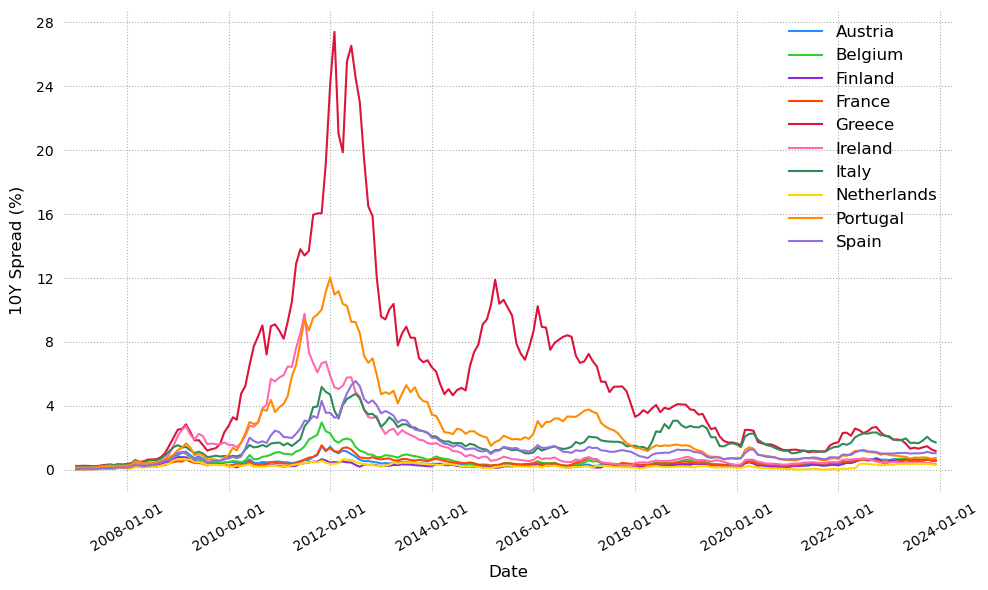

In [33]:
import matplotlib.dates as mdates  # Import for date formatting

# Set figure size
plt.figure(figsize=(10, 6)) # for tex document 

# Custom color palette
custom_palette = ["#1E90FF", "#32CD32", "#8A2BE2", "#FF4500", "#DC143C",
                  "#FF69B4", "#2E8B57", "#FFD700", "#FF8C00", "#9370DB"]

# Create line plot custom color palette 
sns.lineplot(data=df, x="Date", y="10Y_Spread", hue="Country_ID", 
             linewidth=1.5, alpha=1, palette=custom_palette)

# Limit x-axis to time series range
start_date = pd.Timestamp("2007-01-01")
end_date = pd.Timestamp("2023-12-31")
margin = pd.Timedelta(days=90)  # adjust margin by 90 days for better viz 
plt.xlim(start_date - margin, end_date + margin)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)

# X-axis labels only every second year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-01-01'))  # Format as 'YYYY-01-01'

# Adjust Grid with rectangular shape
plt.grid(True, which="both", linestyle="dotted", alpha=1)

# Increase horizontal grid lines 
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(10))  

# Remove frame around the plot
for spine in ["top", "right", "left", "bottom"]:
    plt.gca().spines[spine].set_visible(False)  # hides all frames

# Remove dots on both axes
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False, right=False)

# Larger axis titles
plt.xlabel("Date", fontsize=12, labelpad=8) 
plt.ylabel("10Y Spread (%)", fontsize=12, labelpad=8)

# Move legend to the upper right corner + increase size 
plt.legend(loc='upper right', frameon=False, fontsize=12)

# Tighten layout
plt.tight_layout()

# Show plot
plt.show()

In [34]:
# Create descriptive statistics of target variable 

grouped_stats = df.groupby('Country_ID')['10Y_Spread'].agg(
    Mean='mean',
    Median='median',
    StDev='std',
    Min='min',
    Max='max'
)

grouped_stats['Skew'] = df.groupby('Country_ID')['10Y_Spread'].apply(pd.Series.skew)
grouped_stats['Kurt'] = df.groupby('Country_ID')['10Y_Spread'].apply(pd.Series.kurt)
grouped_stats.round(2)

,Mean,Median,StDev,Min,Max,Skew,Kurt
Country_ID,,,,,,,
Austria,0.42,0.35,0.25,0.04,1.49,1.58,3.26
Belgium,0.61,0.47,0.45,0.04,2.97,2.33,6.75
Finland,0.32,0.30,0.15,0.03,0.80,0.87,0.58
France,0.46,0.42,0.24,0.04,1.54,1.73,4.90
Greece,5.58,3.76,5.51,0.23,27.39,1.81,3.58
Ireland,1.51,0.65,1.88,0.02,9.77,2.10,3.87
Italy,1.78,1.60,0.97,0.21,5.19,1.12,1.67
Netherlands,0.25,0.22,0.15,0.01,0.68,0.74,0.45
Portugal,2.47,1.49,2.58,0.14,12.03,1.91,3.21


In [35]:
# exclude Greece (only for second part in analysis)
df = df[df['Country_ID'] != 'Greece']
df.shape

(1836, 154)

#### Exclude Outliers with IQR method

In [36]:
# Calculate the first and third quartiles for target variable
Q1 = df['10Y_Spread'].quantile(0.25)
Q3 = df['10Y_Spread'].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection (1.5 = standard)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe and remove outliers
df = df[(df['10Y_Spread'] >= lower_bound) & (df['10Y_Spread'] <= upper_bound)]

df.shape

(1666, 154)

### 

In [37]:
# split data into training and testing sets 
split_date ='2019-01-01'

# Create train and test data 
train_df = df[df["Date"] < split_date].copy()
test_df = df[df["Date"] >= split_date].copy()

# Reset indices to ensure they are sequential
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# drop non-feature columns 
drop_cols = ["10Y_Spread", "Date", "Country_ID"]
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["10Y_Spread"]
X_test  = test_df.drop(columns=drop_cols)
y_test  = test_df["10Y_Spread"]

# log-transform target to reduce further skew
y_train = np.log1p(y_train)
y_test  = np.log1p(y_test)


### Feature Selection

In [38]:
# create simple RF tree 
rf_boruta = RandomForestRegressor(
    n_jobs=1,
    n_estimators=100,
    max_depth=3,
    max_features='sqrt',
    random_state=21
)

# apply boruta algorithm 
boruta_selector = BorutaPy(
    estimator=rf_boruta,
    n_estimators='auto',
    max_iter=10,
    random_state=21
)

boruta_selector.fit(X_train.values, y_train.values)
selected_features = X_train.columns[boruta_selector.support_]

# Update training and testing sets to contain only the selected features.
X_train = X_train[selected_features]
X_test  = X_test[selected_features]

# Print boruta results 
print('Boruta selected feaures', list(selected_features))
print('Number selected by Boruta', len(selected_features))

Boruta selected feaures ['Inflation_Rate_YoY', 'Unemployment_Rate', 'GDP_Growth_YoY', 'Consumer_Confidence_Index', 'Current_Account_Balance_GDP', 'Debt_to_GDP', 'Debt_Growth_YoY', 'Real_Effective_Exchange_Rate', 'Stock_Market_Return_YoY', 'CBOE_Volatility_Index', 'EUR/USD', 'US_Yield_Curve_Spread', 'Baa_Treasury_Spread', 'EURIBOR', 'FEDECB', 'Rating_ordinal', 'Rating_PD_Pct', 'Stability_Index', 'Unemployment_Diff_GER', 'Consumer_Confidence_Diff_GER', 'GDP_Growth_Diff_GER', 'Current_Account_Diff_GER', 'Debt_to_GDP_Diff_GER', 'Debt_Growth_Diff_GER', 'Pre_Crisis_Dummy', 'Debt_Crisis_Dummy', 'QE_Dummy', 'PreCrisis_Debt_to_GDP_Diff_GER', 'Crisis_Debt_Growth', 'Country_Italy', 'Inflation_Rate_YoY_lag3', 'Inflation_Rate_YoY_lag6', 'Unemployment_Rate_lag3', 'Unemployment_Rate_lag6', 'Unemployment_Rate_lag12', 'Retail_Sales_YoY_lag12', 'GDP_Growth_YoY_lag3', 'GDP_Growth_YoY_lag6', 'GDP_Growth_YoY_lag12', 'Consumer_Confidence_Index_lag3', 'Consumer_Confidence_Index_lag6', 'Consumer_Confidence_In

In [39]:
# Further feature selection for linear model to reduce multicollinearity

# Compute absolute correlation matrix
corr_matrix = X_train.corr().abs()

# Upper triangle mask (excluding diagonal)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Identify features to drop 
to_drop = corr_matrix.columns[
    (corr_matrix.where(upper) > 0.75).any(axis=0)
]

# Show dropped features 
print("Dropping features due to high correlation:", list(to_drop))

# Update datasets only for linear model 
base_X_train = X_train.drop(columns=to_drop)
base_X_test = X_test.drop(columns=to_drop, errors='ignore')

# Show number of features in linear model 
print("Final number of features for SVR linear model:", base_X_train.shape[1])

Dropping features due to high correlation: ['Baa_Treasury_Spread', 'Rating_PD_Pct', 'Unemployment_Diff_GER', 'Current_Account_Diff_GER', 'Debt_to_GDP_Diff_GER', 'Debt_Growth_Diff_GER', 'Pre_Crisis_Dummy', 'QE_Dummy', 'Crisis_Debt_Growth', 'Inflation_Rate_YoY_lag3', 'Inflation_Rate_YoY_lag6', 'Unemployment_Rate_lag3', 'Unemployment_Rate_lag6', 'Unemployment_Rate_lag12', 'GDP_Growth_YoY_lag3', 'GDP_Growth_YoY_lag6', 'Consumer_Confidence_Index_lag3', 'Consumer_Confidence_Index_lag6', 'Consumer_Confidence_Index_lag12', 'Debt_to_GDP_lag3', 'Debt_to_GDP_lag6', 'Debt_to_GDP_lag12', 'Debt_Growth_YoY_lag3', 'Debt_Growth_YoY_lag6', 'Real_Effective_Exchange_Rate_lag3', 'Real_Effective_Exchange_Rate_lag6', 'Real_Effective_Exchange_Rate_lag12', 'Stock_Market_Return_YoY_lag3', 'Stock_Market_Return_YoY_lag6', 'EUR/USD_lag3', 'EUR/USD_lag6', 'US_Yield_Curve_Spread_lag3', 'US_Yield_Curve_Spread_lag6', 'US_Yield_Curve_Spread_lag12', 'Baa_Treasury_Spread_lag3', 'Baa_Treasury_Spread_lag6', 'Baa_Treasury_S

### Model Development

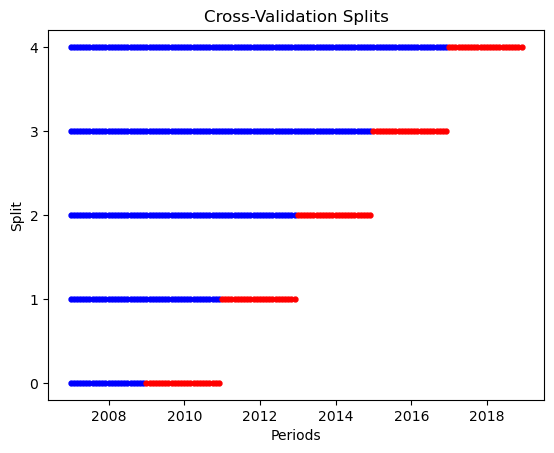

Best RF Parameters: {'max_depth': 5, 'max_features': 0.2, 'n_estimators': 500}
Best SVR Parameters: {'C': 7, 'epsilon': 0.05}
Best SVR Base Model Parameters: {'C': 8, 'epsilon': 0.005}


In [40]:
# create panel cross-validation with PanelSplit 
panel_split = PanelSplit(
    periods=train_df["Date"],
    n_splits=5,                 # number of splits 
    test_size=24,               # 24 month test size 
    gap=0,
    plot=True
)

##### RF Model ##### 

rf_model = RandomForestRegressor(random_state=21, n_jobs=1)

# I only include here the final parameters I already choose by testing 
# this way it needs less computing time 
rf_params = {
  'n_estimators': [500],  
  'max_depth': [5],       
  'max_features': [0.2]
}

# Peform hyper-parameter tuning 
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    scoring='neg_mean_squared_error',
    cv=panel_split,
    n_jobs=1
)

# fit gridsearch on train data 
rf_grid.fit(X_train, y_train)
print('Best RF Parameters:', rf_grid.best_params_) # print optimal hyper-parameters 


##### SVR Model #####

# Create MinMaxScaler to ensure normalized SVR data 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initilize SVR model 
svr_model = SVR()

# Here, I also only show the final parameters due to computing time 
svr_params = {
    'C': [7],
    'epsilon': [0.05]
}

# Peform hyper-parameter tuning  
svr_grid = GridSearchCV(
    estimator=svr_model,
    param_grid=svr_params,
    scoring='neg_mean_squared_error',
    cv=panel_split,
    n_jobs=1
)

# Fit SVR grid search with the scaled features
svr_grid.fit(X_train_scaled, y_train)
print('Best SVR Parameters:', svr_grid.best_params_)


##### SVR linear base Model #####

# scale on reduced features for linear model (multicollinearity)
base_X_train_scaled = scaler.fit_transform(base_X_train)
base_X_test_scaled = scaler.transform(base_X_test)

# Initialize SVR with linear kernel 
base_model = SVR(kernel='linear')

# Here, I also only include the final parameters due to computing time
base_params = {
    'C': [8],
    'epsilon': [0.005]
}

# Perform hyper-parameter tuning 
base_grid = GridSearchCV(
    estimator=base_model,
    param_grid=base_params,
    scoring='neg_mean_squared_error',
    cv=panel_split,
    n_jobs=1
)

# Fit SVR grid search with the scaled features
base_grid.fit(base_X_train_scaled, y_train)
print('Best SVR Base Model Parameters:', base_grid.best_params_)


## Predictive Performance and Model Evaluation 

In [41]:
##### RF Model #####

# Retrieve the best RF model from gridsearch
rf_best = rf_grid.best_estimator_

# Make predictions on the test
rf_preds_log = rf_best.predict(X_test)

# Convert predictions back to original scale (exponential transformation)
rf_preds = np.expm1(rf_preds_log)
y_test_original = np.expm1(y_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test_original, rf_preds)  # Mean squared error
rf_rmse = np.sqrt(rf_mse)  # Root mean squared error
rf_mae = mean_absolute_error(y_test_original, rf_preds)  # Mean absolute error
rf_r2 = r2_score(y_test_original, rf_preds)  # R-squared score

# Print model evaluation metrics
print("Random Forest Model Evaluation:")
print("MSE: {:.4f}".format(rf_mse))   
print("RMSE: {:.4f}".format(rf_rmse)) 
print("MAE: {:.4f}".format(rf_mae))   
print("R^2: {:.4f}".format(rf_r2))


##### SVR Model #####

# Apply the same process for the SVR models 
# Retrieve the best SVR model from GridSearchCV
svr_best = svr_grid.best_estimator_

# Make predictions on the scaled test set (log-transformed)
svr_preds_log = svr_best.predict(X_test_scaled)

# Convert predictions back to original scale (exponential transformation)
svr_preds = np.expm1(svr_preds_log)

# Calculate evaluation metrics
svr_mse = mean_squared_error(y_test_original, svr_preds)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test_original, svr_preds)
svr_r2 = r2_score(y_test_original, svr_preds)

# Print model evaluation metrics
print("\nSVR Model Evaluation:")
print("MSE: {:.4f}".format(svr_mse))   
print("RMSE: {:.4f}".format(svr_rmse))  
print("MAE: {:.4f}".format(svr_mae))   
print("R²: {:.4f}".format(svr_r2))


##### SVR linear base model #####

# Retrieve the best linear base SVR model from gridsearch
base_best = base_grid.best_estimator_

# Make predictions on the scaled test set (log-transformed)
base_preds_log = base_best.predict(base_X_test_scaled)

# Convert predictions back to original scale (exponential transformation)
base_preds = np.expm1(base_preds_log)

# Calculate evaluation metrics
base_mse = mean_squared_error(y_test_original, base_preds)
base_rmse = np.sqrt(base_mse)
base_mae = mean_absolute_error(y_test_original, base_preds)
base_r2 = r2_score(y_test_original, base_preds)

# Print model evaluation metrics
print("\nSVR Base Model Evaluation:")
print("MSE: {:.4f}".format(base_mse))
print("RMSE: {:.4f}".format(base_rmse))
print("MAE: {:.4f}".format(base_mae))
print("R²: {:.4f}".format(base_r2))


Random Forest Model Evaluation:
MSE: 0.0608
RMSE: 0.2466
MAE: 0.1929
R^2: 0.7087

SVR Model Evaluation:
MSE: 0.0531
RMSE: 0.2305
MAE: 0.1682
R²: 0.7455

SVR Base Model Evaluation:
MSE: 0.0765
RMSE: 0.2766
MAE: 0.2029
R²: 0.6334


In [42]:
# MSE metrics by years 

# Add year column to test data
test_df['Year'] = test_df['Date'].dt.year

# function to compute yearly MSE
def yearly_mse(y_true, y_pred, test_df):
    results = {}
    for year in [2019, 2020, 2021, 2022, 2023]:
        mask = test_df['Year'] == year
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        results[year] = round(mse, 3)
    return results

# Compute yearly MSE for RF
rf_yearly = yearly_mse(y_test_original, rf_preds, test_df)
print(rf_yearly)

# Compute yearly MSE for SVR RBF 
svr_yearly = yearly_mse(y_test_original, svr_preds, test_df)
print(svr_yearly)

# Compute yearly MSE for linear base SVR
base_yearly = yearly_mse(y_test_original, base_preds, test_df)
print(base_yearly)

{2019: 0.028, 2020: 0.05, 2021: 0.025, 2022: 0.104, 2023: 0.095}
{2019: 0.072, 2020: 0.089, 2021: 0.059, 2022: 0.022, 2023: 0.024}
{2019: 0.014, 2020: 0.123, 2021: 0.053, 2022: 0.045, 2023: 0.145}


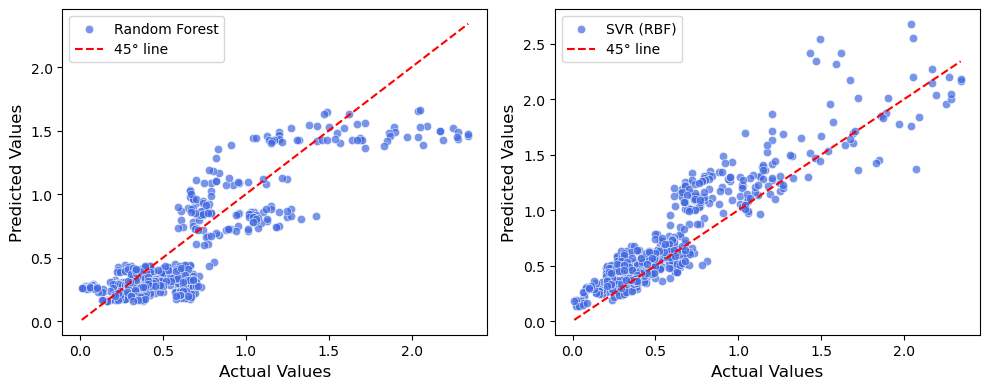

In [43]:
# Set figure size for tex document 
plt.figure(figsize=(10, 4))

# RF plot: actual vs. predicted values
plt.subplot(1, 2, 1)  # Create first subplot
sns.scatterplot(x=y_test_original, y=rf_preds, alpha=0.7, color='royalblue', label="Random Forest")  
plt.plot([y_test_original.min(), y_test_original.max()],  # Plot a 45-degree reference line
         [y_test_original.min(), y_test_original.max()], 
         "r--", label="45° line")  
plt.xlabel("Actual Values", fontsize=12) 
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()

# SVR plot: actual vs. predicted values
plt.subplot(1, 2, 2)  # Create second subplot
sns.scatterplot(x=y_test_original, y=svr_preds, alpha=0.7, color='royalblue', label="SVR (RBF)")  
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 
         "r--", label="45° line")  
plt.xlabel("Actual Values", fontsize=12)  
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show plots

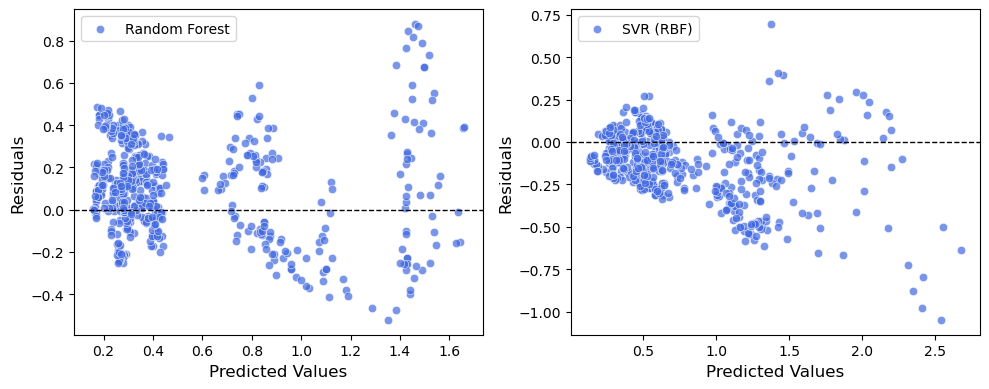

In [44]:
# Calculate residuals for both ML models
rf_residuals_orig = y_test_original - rf_preds
svr_residuals_orig = y_test_original - svr_preds

# Set figure size for tex document
plt.figure(figsize=(10, 4))

# Residual plot for Random Forest model
plt.subplot(1, 2, 1)  # Create first subplot
sns.scatterplot(x=rf_preds, y=rf_residuals_orig, alpha=0.7, color='royalblue', label="Random Forest")  
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Horizontal reference line at zero residual
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend(fontsize=10)  # Legend with smaller font size

# Residual plot for SVR model
plt.subplot(1, 2, 2)  # Create second subplot
sns.scatterplot(x=svr_preds, y=svr_residuals_orig, alpha=0.7, color='royalblue', label="SVR (RBF)")  
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend(fontsize=10, loc='upper left')  # Legend with smaller font size, also in upper left

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

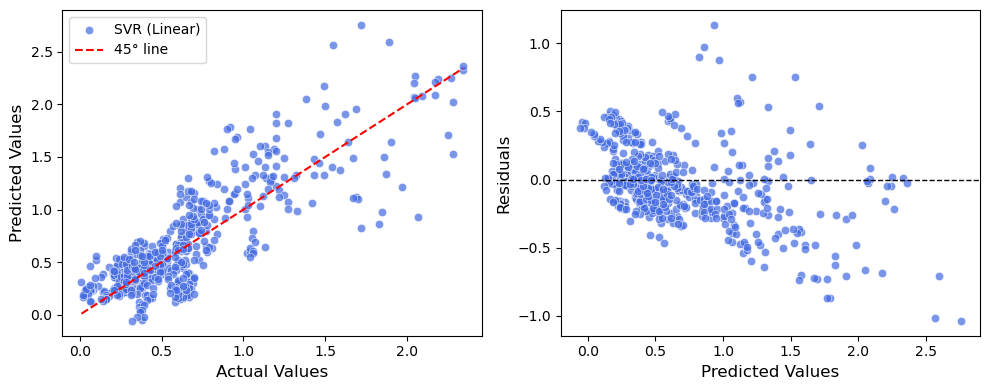

In [45]:
# Calculate residuals for the SVR linear base model
base_residuals_orig = y_test_original - base_preds

# Create figure with 2 subplots
plt.figure(figsize=(10, 4))  # Set figure size

# SVR linear: actual vs predicted values
plt.subplot(1, 2, 1)  # Create first subplot
sns.scatterplot(x=y_test_original, y=base_preds, alpha=0.7, color='royalblue', label="SVR (Linear)")
plt.plot([y_test_original.min(), y_test_original.max()],  # plot a 45-degree reference line
         [y_test_original.min(), y_test_original.max()], 
         "r--", label="45° line")  
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()

# SVR linear: residuals plot 
plt.subplot(1, 2, 2)  # Create second subplot
sns.scatterplot(x=base_preds, y=base_residuals_orig, alpha=0.7, color='royalblue')  
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Horizontal reference line at zero residual
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Variable Importance and Key Drivers of Spreads

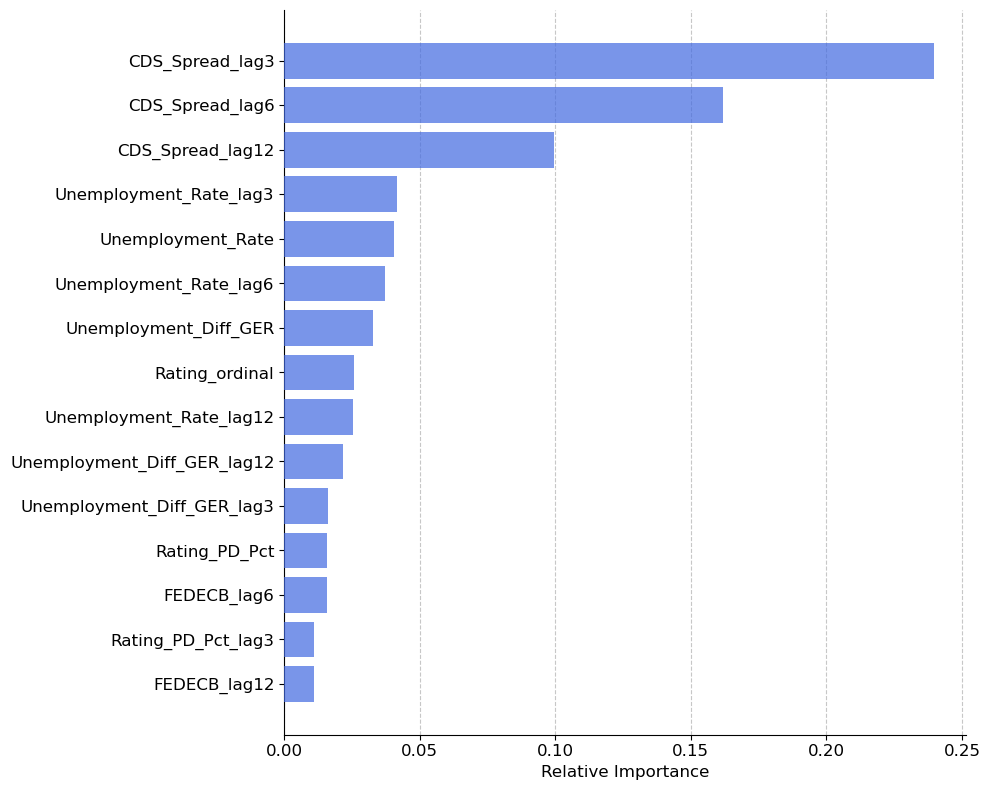

In [46]:
# Set number of top features to visualize
top_n = 15  

# Retrieve feature names from training data
feature_names = X_train.columns.tolist()

# Get feature importances from the RF model
importances = rf_best.feature_importances_

# Sort feature importances in descending order and select the top n features
indices = np.argsort(importances)[::-1][:top_n]  
top_features = [feature_names[i] for i in indices]  # get feature names
top_importances = importances[indices]  # get importance values

# Create horizontal plot for feature importances
plt.figure(figsize=(10, 8))  # Set figure size for tex document 

ax = plt.gca()  # Get current axes for customization

# Invert y-axis so the most important feature appears at the top
ax.invert_yaxis()

# Ensure grid lines appear behind the bars
ax.set_axisbelow(True)

# Add vertical grid lines for reference
ax.xaxis.grid(True, which='major', linestyle='--', alpha=0.7, zorder=0)

# Plot top feature importances as horizontal bars
plt.barh(top_features, top_importances, color='royalblue', alpha=0.7,
         edgecolor='none', zorder=3)  # bars placed above the grid (zorder=3)

# Label x-axis
plt.xlabel("Relative Importance", fontsize=12)

# Adjust tick label sizes for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines to make the plot cleaner
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optimize layout to prevent overlapping
plt.tight_layout()

plt.show()

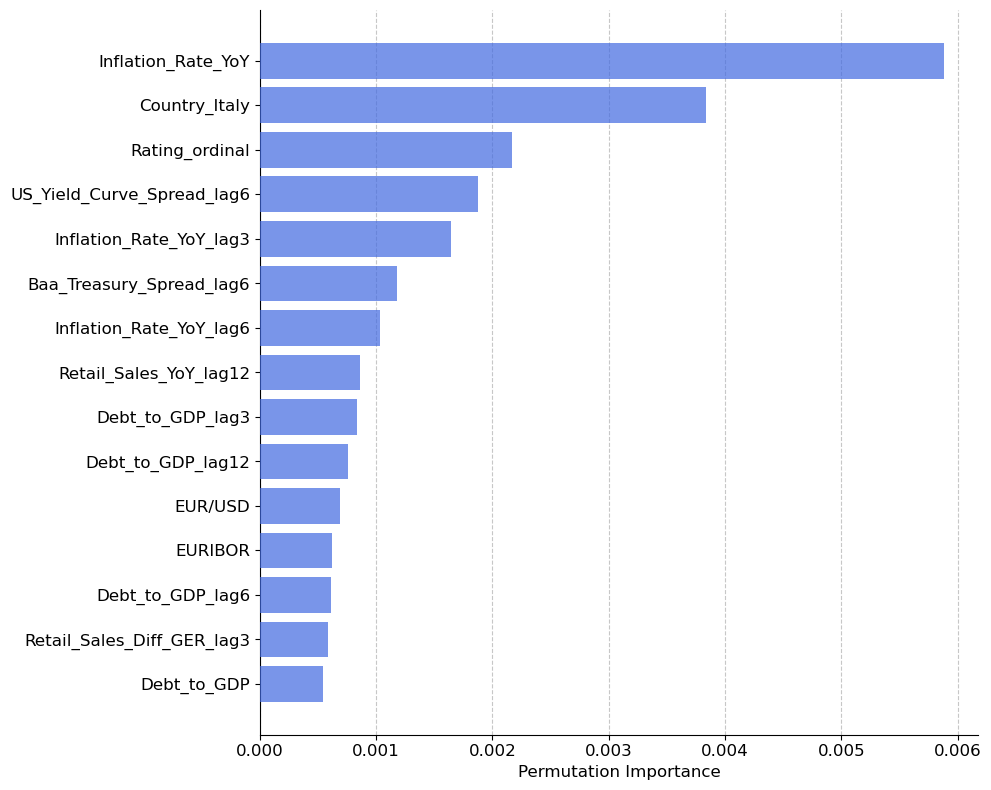

In [47]:
# Compute permutation importance for SVR model
result = permutation_importance(
    estimator=svr_best,                 # Use the best SVR model
    X=X_test_scaled,                    # Use scaled test data
    y=y_test,                           # Use actual target values
    scoring="neg_mean_squared_error",   # Evaluate using negative MSE
    n_repeats=5,                        # Perform 5 repeated shuffles for stability
    random_state=21,                    
    n_jobs=-1 
)

# Extract mean importance values from permutation results
importances_mean = result.importances_mean

# set number of top features to visualize
top_n = 15  

# Sort features by importance in descending order and select the top n
indices = np.argsort(importances_mean)[::-1][:top_n]  
top_features = [feature_names[i] for i in indices]  # get feature names
top_importances = importances_mean[indices]  # get importance values

# Create horizontal bar plot for permutation importances
plt.figure(figsize=(10, 8))  # Set figure size
ax = plt.gca()  # get current axes for customization

# Invert y-axis so the most important feature appears at top
ax.invert_yaxis()

# Ensure grid lines appear behind the bars for better look
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', alpha=0.7, zorder=0)

# Plot the top feature importances as horizontal bars
plt.barh(top_features, top_importances, color='royalblue', alpha=0.7,
         edgecolor='none', zorder=3)  # bars placed above the grid (zorder=3)

# Label x-axis to permutation importance
plt.xlabel("Permutation Importance", fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines to make the plot cleaner
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optimize layout to prevent overlapping
plt.tight_layout()

plt.show()